In [ ]:
%cd ..

In [ ]:
import librosa
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

from evoaudio.base_algorithms import approximate_piece
from evoaudio.base_sample import BaseSample
from evoaudio.individual import BaseIndividual
from evoaudio.mutations import Mutator
from evoaudio.population import Population
from evoaudio.sample_library import SampleLibrary
from evoaudio.population_logging import PopulationLogger
from evoaudio.jaccard import calc_jaccard_for_chord_approximation
from parsing.arff_parsing import parse_arff

In [ ]:
sample_lib = SampleLibrary()

In [4]:
N_INDIVIDUALS = 100

MAX_STEPS = 10000
POPSIZE = 10
N_OFFSPRING = 1

Create set of randomly generated individuals with varying offsets on their samples

In [8]:
class GroundTruthIndividual(BaseIndividual):
    def __init__(self, phi: float = 0.1, hold_delay: int = 5512):
        super().__init__(phi)
        #self.hold_delay = np.random.randint(low=0, high=44100) # Random delay between 0 and 2 seconds
        self.hold_delay = 5512
        self.holds = []

    def __str__(self):
        s = f"Fitness: {self.fitness} | " + ", ".join(str(x) for x in self.samples) + ", ".join(str(hold) for hold in self.holds)
        return s

    def add_sample(self, sample:BaseSample, hold:bool):
        self.samples.append(sample)
        self.holds.append(hold)

    def remove_sample(self, remove_idx):
        self.samples.pop(remove_idx)
        self.holds.pop(remove_idx)

    def to_mixdown(self) -> np.ndarray:
        """Creates a mix of the samples contained in the collection.

        Returns
        -------
        np.ndarray
            Mix of the samples.
        """
        ys_holding = []
        for i in range(len(self.samples)):
            if self.holds[i]:
                ys_holding.append(self.samples[i].y[self.hold_delay:])
            else:
                ys_holding.append(self.samples[i].y)
        # Resize by expanding all samples to the same length
        max_length = np.max([len(y) for y in ys_holding])
        ys_equal_length = [np.pad(y, (0, max_length - len(y))) for y in ys_holding]
        return np.sum(ys_equal_length, axis=0)
    
    @classmethod
    def create_random_individual(cls, sample_lib:SampleLibrary, max_samples:int=5, sample_num_p:list[float]=[0.1, 0.3, 0.3, 0.2, 0.1], phi:float=0.1):
        individual = cls(phi=phi)
        for _ in range(np.random.choice(list(range(max_samples)), p=sample_num_p) + 1):
            individual.add_sample(sample_lib.get_random_sample_uniform(), hold=np.random.choice(a=[False, True], p=[0.8, 0.2]))
        return individual

true_individuals = [GroundTruthIndividual.create_random_individual(sample_lib=sample_lib) for _ in range(N_INDIVIDUALS)]


In [6]:
class Logger():
    def __init__(self) -> None:
        self.logged_errors = []
        self.logged_fitnesses = []
    def log_errors(self, pop, annotation):
        errors = calc_jaccard_for_chord_approximation(pop=pop, annotation=annotation)
        self.logged_errors.append(errors)
    def log_fitness(self, pop):
        self.logged_fitnesses.append(pop.archive[0].fitness)

In [9]:
results = []
error_logs = []
fitness_logs = []
def callback(pop:Population, step:int):
    annotation = [(sample.instrument, sample.pitch) for sample in true_ind.samples]
    logger.log_errors(pop=pop, annotation=annotation)
    logger.log_fitness(pop=pop)

for true_ind in true_individuals:
    print("Searching for: " + str(true_ind))
    logger = Logger()
    # mutator = Mutator(sample_library=sample_lib, choose_mutation_p=[0.3, 0.6, 0.1])
    mutator = Mutator(sample_library=sample_lib, choose_mutation_p=[0.4, 0.4, 0.1, 0.1])
    result = approximate_piece(
        target_y=true_ind.to_mixdown(), 
        max_steps=MAX_STEPS, 
        sample_lib=sample_lib, 
        popsize=POPSIZE, 
        n_offspring=N_OFFSPRING, 
        onset_frac=1.0, zeta=0.9954,
        early_stopping_fitness=0.0001,
        onsets=[0], verbose=True, callback=callback)
    error_logs.append(logger.logged_errors)
    fitness_logs.append(logger.logged_fitnesses)
    print("-----------------------------------")
    results.append(result)

Searching for: Fitness: inf | (Violin, Violins_SessionStringsPro, e5), (MorinKhuurViolin, morin_khuur_violin, ais5), (Tuba, Tuba_SessionHornsPro, e4)True, False, False


100%|██████████| 10000/10000 [00:48<00:00, 205.79it/s, Best individual: Fitness: 0.005582730828261957 | (Violin, Violins_SessionStringsPro, e5), (ElectricBass, Scarbee_MMBass_Amped_Pop, e4), (MorinKhuurViolin, morin_khuur_violin, ais5)True, True, False]                                           


-----------------------------------
Searching for: Fitness: inf | (Melodica, melodica, dis4), (EgyptianFiddle, egyptian_fiddle, e2), (Bandura, bandura, e3)False, False, False


100%|██████████| 10000/10000 [00:50<00:00, 196.36it/s, Best individual: Fitness: 0.15966606326219512 | (Melodica, melodica, dis4), (EgyptianFiddle, egyptian_fiddle, e2), (Ukulele, ukulele, b4), (Shakuhachi, shakuhachi, e4), (Fujara, fujara, b4)False, True, True, False, False]


-----------------------------------
Searching for: Fitness: inf | (CeylonGuitar, ceylon_guitar, c2), (Balalaika, balalaika, dis3), (PivanaFlute, pivana_flute, fis5), (Bawu, bawu, f5)True, False, False, False


100%|██████████| 10000/10000 [00:51<00:00, 194.24it/s, Best individual: Fitness: 0.15156900545445884 | (Drums, ARVintage_IvoryKit, Snare_Halfway), (Balalaika, balalaika, dis3), (Bawu, bawu, f5), (Pinkillo, pinkillo, g5)True, False, False, True]                                     


-----------------------------------
Searching for: Fitness: inf | (JinghuOperaviolin, jinghu_opera_violin, d6), (Erhu, erhu_key, dis4), (Panflute, panflute, cis5), (Bassoon, Bassoons_Essential, e4)False, False, False, True


 23%|██▎       | 2273/10000 [00:11<00:39, 194.50it/s, Best individual: Fitness: -1.1164967606707317e-08 | (JinghuOperaviolin, jinghu_opera_violin, d6), (Panflute, panflute, cis5), (Bassoon, Bassoons_Essential, e4), (Erhu, erhu_key, dis4)False, False, True, False]                             


-----------------------------------
Searching for: Fitness: inf | (Dilruba, dilruba, ais4), (ElectricBass, Scarbee_JayBass_Slap_Neck, fis1), (Organ, Errol_G, g5), (PivanaFlute, pivana_flute, b5)False, False, False, False


100%|██████████| 10000/10000 [00:50<00:00, 196.39it/s, Best individual: Fitness: 0.33443838724275915 | (ElectricBass, Scarbee_JayBass_Slap_Neck, fis1), (Dilruba, dilruba, ais4), (Organ, Errol_G, g5), (Cello, tr173VCNVM, a2)False, True, True, False]                                            


-----------------------------------
Searching for: Fitness: inf | (Bass, Basses_SessionStringsPro, dis2), (Viola, tr161VLNVM, c6), (Organ, Basic_Jazz_2, c4)False, False, False


100%|██████████| 10000/10000 [00:49<00:00, 200.25it/s, Best individual: Fitness: 0.0368534106743045 | (Bass, Basses_SessionStringsPro, dis2), (Viola, tr161VLNVM, c6), (DungDkarTrumpet, dung_dkar_trumpet, c4)True, False, False]                                


-----------------------------------
Searching for: Fitness: inf | (Pinkillo, pinkillo, gis5), (ElectricBass, Scarbee_MMBass_Amped_Pop, c4), (CeylonGuitar, ceylon_guitar, a3)False, False, False


100%|██████████| 10000/10000 [00:47<00:00, 209.80it/s, Best individual: Fitness: 0.09306016875476372 | (CeylonGuitar, ceylon_guitar, a3), (Horn, Horn1_Essential, c2), (Pinkillo, pinkillo, gis5)False, False, False]                                             


-----------------------------------
Searching for: Fitness: inf | (BanjoFramus, banjo_framus, fis4), (Saxophone, Saxophones_Essential, cis5)True, False


 39%|███▊      | 3854/10000 [00:16<00:26, 227.89it/s, Best individual: Fitness: 0.0 | (Saxophone, Saxophones_Essential, cis5), (BanjoFramus, banjo_framus, fis4)False, True]                                              


-----------------------------------
Searching for: Fitness: inf | (Oud, oud, b2), (Erhu, erhu_key, e4)False, False


 19%|█▉        | 1935/10000 [00:08<00:36, 223.52it/s, Best individual: Fitness: 0.0 | (Erhu, erhu_key, e4), (Oud, oud, b2)False, False]                                                                                                                                                         


-----------------------------------
Searching for: Fitness: inf | (Bass, Basses_Essential, dis3)False


 12%|█▏        | 1154/10000 [00:05<00:41, 214.76it/s, Best individual: Fitness: 0.0 | (Bass, Basses_Essential, dis3)False]                                                                                                                                


-----------------------------------
Searching for: Fitness: inf | (Bass, Basses_SessionStringsPro, g2), (ElectricGuitar, tr133EGLFM, ais2), (AcousticGuitar, tr112AGRFM, d3), (Oboe, Oboes_Essential, c6)False, False, False, False


100%|██████████| 10000/10000 [00:48<00:00, 206.85it/s, Best individual: Fitness: 0.10541829178972942 | (Bass, Basses_SessionStringsPro, g2), (Drums, AR50s_SpringKit, Tom4), (Oboe, Oboes_Essential, c6), (ElectricGuitar, tr133EGLFM, ais2)False, True, False, False]                       


-----------------------------------
Searching for: Fitness: inf | (Viola, tr161VLNOM, f3), (AcousticGuitar, tr112AGRFM, ais4)False, False


100%|██████████| 10000/10000 [00:48<00:00, 205.79it/s, Best individual: Fitness: 0.20327679889958078 | (AcousticGuitar, tr112AGRFM, ais4), (Organ, Basic_Jazz_2, f4), (Viola, Violas_SessionStringsPro, f3)False, False, False]                                                         


-----------------------------------
Searching for: Fitness: inf | (Pinkillo, pinkillo, c7)True


 20%|██        | 2040/10000 [00:07<00:30, 258.75it/s, Best individual: Fitness: 0.0 | (Pinkillo, pinkillo, c7)True]                                                         


-----------------------------------
Searching for: Fitness: inf | (Pinkillo, pinkillo, c5), (ScaleChangerHarmonium, scale_changer_harmonium, gis1), (Violin, tr152VNNVM, cis4), (Melodica, melodica, b5)False, True, True, True


 34%|███▍      | 3421/10000 [00:17<00:33, 196.27it/s, Best individual: Fitness: -3.023845393483232e-09 | (ScaleChangerHarmonium, scale_changer_harmonium, gis1), (Violin, tr152VNNVM, cis4), (Melodica, melodica, b5), (Pinkillo, pinkillo, c5)True, True, True, False]                             


-----------------------------------
Searching for: Fitness: inf | (ElectricPiano, Scarbee_MarkI_DI, f3), (Tuba, Tubas_Essential, b4), (Tanbur, tanbur, fis1)False, False, True


100%|██████████| 10000/10000 [00:50<00:00, 199.24it/s, Best individual: Fitness: 0.62015869140625 | (Tuba, Tuba_Essential, cis1), (Horn, Horns_Essential, f2), (ElectricPiano, Scarbee_MarkI_DI, b4), (ElectricPiano, Scarbee_MarkI_PinkPlayboy, f3)False, False, True, False]                          


-----------------------------------
Searching for: Fitness: inf | (Viola, Violas_SessionStringsPro, g5), (Ukulele, ukulele, e5)False, False


 12%|█▏        | 1225/10000 [00:05<00:38, 229.25it/s, Best individual: Fitness: 0.0 | (Viola, Violas_SessionStringsPro, g5), (Ukulele, ukulele, e5)False, False]                                                                     


-----------------------------------
Searching for: Fitness: inf | (Shakuhachi, shakuhachi, gis4), (Trombone, Trombones_Essential, e1)False, True


 15%|█▍        | 1479/10000 [00:06<00:39, 217.71it/s, Best individual: Fitness: 0.0 | (Trombone, Trombones_Essential, e1), (Shakuhachi, shakuhachi, gis4)True, False]                                                                                                                                     


-----------------------------------
Searching for: Fitness: inf | (Bandura, bandura, b5), (DungDkarTrumpet, dung_dkar_trumpet, c5), (Pinkillo, pinkillo, cis5), (Balalaika, balalaika, g3)True, False, False, False


100%|██████████| 10000/10000 [00:49<00:00, 203.84it/s, Best individual: Fitness: 0.11239376905487805 | (Bassoon, Bassoons_Essential, fis3), (Pinkillo, pinkillo, c5), (Balalaika, balalaika, g3), (Bandura, bandura, b5)False, False, False, True]                                              


-----------------------------------
Searching for: Fitness: inf | (Dilruba, dilruba, e5), (ElectricBass, Scarbee_MMBass, cis1), (Melodica, melodica, f4)False, False, False


 47%|████▋     | 4677/10000 [00:23<00:26, 201.30it/s, Best individual: Fitness: 2.209733172160823e-09 | (Dilruba, dilruba, e5), (Melodica, melodica, f4), (ElectricBass, Scarbee_MMBass, cis1)False, False, False]                                                                                              


-----------------------------------
Searching for: Fitness: inf | (Trombone, Trombone_Essential, c2), (Trumpet, tr212TRNOM, c4), (BouzoukiSakis, boizouki, ais5), (Melodica, melodica, g5)False, False, True, False


100%|██████████| 10000/10000 [00:49<00:00, 202.74it/s, Best individual: Fitness: 0.10884904814929497 | (Trombone, Trombone_Essential, c2), (Trumpet, tr212TRNOM, c4), (Clarinet, Clarinets_Essential, ais5), (Melodica, melodica, g5)False, False, False, False]                                          


-----------------------------------
Searching for: Fitness: inf | (AcousticGuitar, tr112AGAPM, f4), (Violin, tr152VNNOM, d5)False, False


 20%|█▉        | 1981/10000 [00:08<00:33, 240.63it/s, Best individual: Fitness: 0.0 | (AcousticGuitar, tr112AGAPM, f4), (Violin, tr152VNNOM, d5)False, False]                                                                           


-----------------------------------
Searching for: Fitness: inf | (Oboe, Oboe_Essential, e4), (PivanaFlute, pivana_flute, a5), (Bass, Basses_SessionStringsPro, b1), (Bawu, bawu, a4)False, False, True, False


100%|██████████| 10000/10000 [00:49<00:00, 201.39it/s, Best individual: Fitness: 0.11178790580935595 | (Bass, Basses_SessionStringsPro, b1), (ElectricPiano, Scarbee_MarkI_PinkPlayboy, a5), (Oboe, Oboe_Essential, e4), (Fujara, fujara, a4)True, True, False, False]          


-----------------------------------
Searching for: Fitness: inf | (Bassoon, Basson_Essential, fis2), (Saxophone, Saxophones_Essential, e3), (Panflute, panflute, d5)False, False, False


100%|██████████| 10000/10000 [00:53<00:00, 188.29it/s, Best individual: Fitness: 0.5549226491044207 | (Saxophone, Saxophones_Essential, e3), (Bassoon, Basson_Essential, fis2), (Shakuhachi, shakuhachi, fis4), (Organ, C3_Jazz, d4)False, False, False, True]          


-----------------------------------
Searching for: Fitness: inf | (Pinkillo, pinkillo, gis5), (Piano, tr011PFPEM, a5), (Tuba, Tuba_SessionHornsPro, cis3), (Erhu, erhu_key, ais4), (CumbusOpenStrings, cumbus, cis4)False, False, False, True, False


100%|██████████| 10000/10000 [00:55<00:00, 180.26it/s, Best individual: Fitness: 0.012118135777915396 | (Piano, tr011PFPEM, a5), (Erhu, erhu_key, ais4), (Trombone, Trombone_Essential, cis3), (CumbusOpenStrings, cumbus, cis4), (Pinkillo, pinkillo, gis5)False, True, True, False, False]                                                 


-----------------------------------
Searching for: Fitness: inf | (Bandura, bandura, f3)False


 36%|███▌      | 3606/10000 [00:14<00:25, 253.51it/s, Best individual: Fitness: 0.0 | (Bandura, bandura, f3)False]                                                                                                           


-----------------------------------
Searching for: Fitness: inf | (Cello, tr171VCSOM, b4), (Shakuhachi, shakuhachi, d6)False, False


100%|██████████| 10000/10000 [00:47<00:00, 211.94it/s, Best individual: Fitness: 0.7408436547256098 | (Drums, AR80s_BlackKit, Kick1), (Cello, tr173VCNOM, b4), (Oboe, Oboe_Essential, d6), (Cello, tr171VCNVM, b4)False, False, False, False]                   


-----------------------------------
Searching for: Fitness: inf | (Shakuhachi, shakuhachi, ais4), (Bawu, bawu, f4), (Balalaika, balalaika, fis4)False, True, False


 23%|██▎       | 2299/10000 [00:10<00:36, 210.29it/s, Best individual: Fitness: -5.2335785656440546e-09 | (Balalaika, balalaika, fis4), (Bawu, bawu, f4), (Shakuhachi, shakuhachi, ais4)False, True, False]                                                                     


-----------------------------------
Searching for: Fitness: inf | (AcousticGuitar, tr111AGRFM, d3), (PivanaFlute, pivana_flute, f5), (Saxophone, Saxophones_Essential, b5)True, True, False


 22%|██▏       | 2165/10000 [00:09<00:35, 220.39it/s, Best individual: Fitness: 2.209733172160823e-09 | (PivanaFlute, pivana_flute, f5), (Saxophone, Saxophones_Essential, b5), (AcousticGuitar, tr111AGRFM, d3)True, False, True]


-----------------------------------
Searching for: Fitness: inf | (Dilruba, dilruba, cis5), (PivanaFlute, pivana_flute, g6), (Organ, Errol_G, cis5), (Balalaika, balalaika, e3)False, False, False, True


100%|██████████| 10000/10000 [00:52<00:00, 191.28it/s, Best individual: Fitness: 0.7725050019054878 | (MorinKhuurViolin, morin_khuur_violin, cis5), (MorinKhuurViolin, morin_khuur_violin, cis5), (Fujara, fujara, e3), (Shakuhachi, shakuhachi, b4), (Trumpet, Trumpet2_SessionHornsPro, cis6)True, True, False, False, False]


-----------------------------------
Searching for: Fitness: inf | (DallapeAccordion, dallape_accordion, c3), (Balalaika, balalaika, f3)False, False


 47%|████▋     | 4734/10000 [00:21<00:23, 222.57it/s, Best individual: Fitness: 0.0 | (DallapeAccordion, dallape_accordion, c3), (Balalaika, balalaika, f3)False, False]                                                                                 


-----------------------------------
Searching for: Fitness: inf | (BouzoukiSakis, boizouki, a3), (Domra, domra, g3)True, False


 52%|█████▏    | 5186/10000 [00:27<00:25, 187.12it/s, Best individual: Fitness: 0.0 | (BouzoukiSakis, boizouki, a3), (Domra, domra, g3)True, False]                                                                                                                                                   


-----------------------------------
Searching for: Fitness: inf | (CumbusOpenStrings, cumbus, cis4), (Contrabassoon, Contrabassoon_Essential, g2)False, False


 47%|████▋     | 4739/10000 [00:21<00:24, 215.48it/s, Best individual: Fitness: 0.0 | (CumbusOpenStrings, cumbus, cis4), (Contrabassoon, Contrabassoon_Essential, g2)False, False]                                                                                     


-----------------------------------
Searching for: Fitness: inf | (BouzoukiSakis, boizouki, dis4), (BanjoFramus, banjo_framus, fis5), (JinghuOperaviolin, jinghu_opera_violin, c5), (ElectricPiano, Scarbee_Clavinet_Full_DI, ais1)False, False, True, False


100%|██████████| 10000/10000 [00:54<00:00, 183.67it/s, Best individual: Fitness: 0.3907010110994665 | (Tuba, Tuba_SessionHornsPro, d4), (JinghuOperaviolin, jinghu_opera_violin, c5), (Piano, The_Giant_soft, c8), (BouzoukiSakis, boizouki, dis4), (Piano, The_Gentleman, ais2)False, True, False, False, False]             


-----------------------------------
Searching for: Fitness: inf | (Bawu, bawu, b4)False


  9%|▊         | 865/10000 [00:03<00:34, 261.25it/s, Best individual: Fitness: 0.0 | (Bawu, bawu, b4)False]                                         


-----------------------------------
Searching for: Fitness: inf | (Trombone, Trombones_Essential, b1), (CumbusOpenStrings, cumbus, f3), (Drums, AR50s_SpringKit, Kick2)False, False, False


100%|██████████| 10000/10000 [00:50<00:00, 199.04it/s, Best individual: Fitness: 0.09580177865377286 | (CumbusOpenStrings, cumbus, f3), (Trombone, BassTrombone_SessionHornsPro, dis1), (Bassoon, Bassoons_Essential, b1), (Organ, Basic_Jazz_2, c1)False, False, True, False]                                       


-----------------------------------
Searching for: Fitness: inf | (AcousticGuitar, tr113AGRFM, c3), (Oboe, Oboe_Essential, e4)False, True


 46%|████▌     | 4558/10000 [00:21<00:25, 214.73it/s, Best individual: Fitness: 0.0 | (AcousticGuitar, tr113AGRFM, c3), (Oboe, Oboe_Essential, e4)False, True]                                                              


-----------------------------------
Searching for: Fitness: inf | (Dilruba, dilruba, c3), (Piano, tr013PFNOM, e6)False, False


100%|██████████| 10000/10000 [00:42<00:00, 233.33it/s, Best individual: Fitness: 0.2595142197027439 | (Dilruba, dilruba, c3), (Ukulele, ukulele, e5), (AcousticGuitar, tr112AGRFM, c3), (Oud, oud, dis5)False, True, True, True]


-----------------------------------
Searching for: Fitness: inf | (Bawu, bawu, d4), (Contrabassoon, Contrabassoon_Essential, ais0), (EgyptianFiddle, egyptian_fiddle, e3), (ElectricGuitar, tr132EGVPM, gis2)False, False, False, False


100%|██████████| 10000/10000 [00:53<00:00, 185.81it/s, Best individual: Fitness: 0.04069853991996951 | (Bass, Basses_SessionStringsPro, gis1), (EgyptianFiddle, egyptian_fiddle, e3), (Tuba, Tuba_SessionHornsPro, b0), (Bawu, bawu, d4), (Tuba, Tubas_Essential, d3)False, False, False, False, False]


-----------------------------------
Searching for: Fitness: inf | (Drums, ARMordern_WhiteKit, Snare_WiresOff), (ElectricPiano, Scarbee_A200_DI, cis4), (BanjoFramus, banjo_framus, g5), (Saxophone, Saxophones_Essential, d4), (Oboe, Oboe_Essential, e4)False, False, True, False, True


100%|██████████| 10000/10000 [00:48<00:00, 208.22it/s, Best individual: Fitness: 0.5359931164253049 | (ElectricPiano, Scarbee_A200_DI, cis4), (Drums, AR50s_AutumnKit, Snare_Center), (Violin, tr152VNNVM, d4), (Horn, Horn1_Essential, e5)False, False, False, False]                      


-----------------------------------
Searching for: Fitness: inf | (EgyptianFiddle, egyptian_fiddle, f2), (Violin, Violins2_Essential, a5), (Piano, The_Grandeur, fis4)False, False, False


 90%|█████████ | 9013/10000 [00:43<00:04, 209.37it/s, Best individual: Fitness: -1.1048665860804116e-08 | (EgyptianFiddle, egyptian_fiddle, f2), (Piano, The_Grandeur, fis4), (Violin, Violins2_Essential, a5)False, False, False]                                                                                


-----------------------------------
Searching for: Fitness: inf | (Banjolin, banjolin, d5), (Erhu, erhu_key, e5)False, False


  6%|▌         | 615/10000 [00:02<00:39, 239.49it/s, Best individual: Fitness: 0.0 | (Erhu, erhu_key, e5), (Banjolin, banjolin, d5)False, False]                                                                                                


-----------------------------------
Searching for: Fitness: inf | (Organ, The_Worm, g5), (Oud, oud, fis3), (PivanaFlute, pivana_flute, fis6)False, False, False


100%|██████████| 10000/10000 [00:43<00:00, 230.76it/s, Best individual: Fitness: 0.8037532155106707 | (Drums, ARMordern_WhiteKit, Tom1), (Organ, C3_Jazz, g5), (Horn, Horn1_Essential, fis5)False, False, False]                                


-----------------------------------
Searching for: Fitness: inf | (Cello, tr172VCNVM, fis2), (Bandura, bandura, dis5), (Organ, The_Worm, c6), (Drums, AR60s_LateKit, Snare_WiresOff), (Oud, oud, g3)False, False, False, True, False


100%|██████████| 10000/10000 [00:49<00:00, 203.54it/s, Best individual: Fitness: 0.10188877012671493 | (Organ, The_Worm, c6), (Drums, AR80s_ChromeKit, Tom2), (Bandura, bandura, dis5), (Oud, oud, g3)True, False, False, False]                                                               


-----------------------------------
Searching for: Fitness: inf | (Domra, domra, dis5), (Drums, AR80s_ChromeKit, Crash2_Tip)False, False


 14%|█▍        | 1376/10000 [00:05<00:37, 230.64it/s, Best individual: Fitness: 0.0 | (Drums, AR80s_ChromeKit, Crash2_Tip), (Domra, domra, dis5)False, False]                                                                                                                    


-----------------------------------
Searching for: Fitness: inf | (Domra, domra, c5), (Domra, domra, ais5), (Banjolin, banjolin, c5)False, True, True


 75%|███████▌  | 7503/10000 [00:32<00:10, 230.56it/s, Best individual: Fitness: -4.419466344321646e-09 | (Domra, domra, c5), (Banjolin, banjolin, c5), (Domra, domra, ais5)False, True, True]                                        


-----------------------------------
Searching for: Fitness: inf | (PivanaFlute, pivana_flute, f5), (Oboe, Oboe_Essential, cis5), (Pinkillo, pinkillo, c7)False, False, False


 48%|████▊     | 4839/10000 [00:23<00:24, 209.56it/s, Best individual: Fitness: 1.046715713128811e-09 | (Pinkillo, pinkillo, c7), (Oboe, Oboe_Essential, cis5), (PivanaFlute, pivana_flute, f5)False, False, False]                                                                                      


-----------------------------------
Searching for: Fitness: inf | (Domra, domra, dis3), (Erhu, erhu_key, d5)False, False


 20%|██        | 2033/10000 [00:08<00:33, 235.83it/s, Best individual: Fitness: 0.0 | (Domra, domra, dis3), (Erhu, erhu_key, d5)False, False]                                                                              


-----------------------------------
Searching for: Fitness: inf | (Bandura, bandura, fis5), (Erhu, erhu_key, a3)False, False


  6%|▋         | 626/10000 [00:02<00:41, 225.50it/s, Best individual: Fitness: 0.0 | (Erhu, erhu_key, a3), (Bandura, bandura, fis5)False, False]                                                                                                                                


-----------------------------------
Searching for: Fitness: inf | (Tanbur, tanbur, g2), (Flute, tr331FLNOM, dis4)False, False


 15%|█▌        | 1549/10000 [00:06<00:36, 233.86it/s, Best individual: Fitness: 0.0 | (Tanbur, tanbur, g2), (Flute, tr331FLNOM, dis4)False, False]                                                                                                                                  


-----------------------------------
Searching for: Fitness: inf | (Shakuhachi, shakuhachi, e4), (Domra, domra, g3)False, False


 56%|█████▌    | 5583/10000 [00:24<00:19, 223.93it/s, Best individual: Fitness: 0.0 | (Shakuhachi, shakuhachi, e4), (Domra, domra, g3)False, False]                                                                                                                  


-----------------------------------
Searching for: Fitness: inf | (ElectricBass, Scarbee_PreBass, fis2), (AcousticGuitar, tr112AGRPM, ais4), (CeylonGuitar, ceylon_guitar, a3)True, False, False


100%|██████████| 10000/10000 [00:45<00:00, 217.52it/s, Best individual: Fitness: 0.5948105230564025 | (ElectricPiano, Scarbee_MarkI_PinkPlayboy, fis2), (Drums, ARMordern_SparkleKit, Snare_Flam), (AcousticGuitar, tr112AGRPM, ais4)False, False, False]        


-----------------------------------
Searching for: Fitness: inf | (Fujara, fujara, d6)False


  2%|▏         | 190/10000 [00:00<00:40, 240.35it/s, Best individual: Fitness: 0.0 | (Fujara, fujara, d6)False]                                                                 


-----------------------------------
Searching for: Fitness: inf | (Trombone, TenorTrombone_SessionHornsPro, f3), (Dilruba, dilruba, f3)False, False


100%|██████████| 10000/10000 [00:43<00:00, 227.59it/s, Best individual: Fitness: 0.1330070086223323 | (Trombone, TenorTrombone_SessionHornsPro, f3), (DungDkarTrumpet, dung_dkar_trumpet, c5), (Horn, Horn1_Essential, c5)False, False, False]


-----------------------------------
Searching for: Fitness: inf | (Bandura, bandura, e4), (KanteleLowWideRange, kantele, dis2)False, True


 36%|███▌      | 3596/10000 [00:15<00:28, 225.05it/s, Best individual: Fitness: 0.0 | (Bandura, bandura, e4), (KanteleLowWideRange, kantele, dis2)False, True]                                                                                      


-----------------------------------
Searching for: Fitness: inf | (MorinKhuurViolin, morin_khuur_violin, g3), (Cello, tr171VCNVM, fis2), (TampuraPAndBrothers, tampura, d3)False, False, False


100%|██████████| 10000/10000 [00:49<00:00, 202.73it/s, Best individual: Fitness: 0.2754543992949695 | (Piano, The_Maverick, g5), (TampuraPAndBrothers, tampura, d3), (Drums, AR70s_OpenKit, Snare_WiresOff), (Cello, tr171VCNVM, fis2)True, False, False, False]                         


-----------------------------------
Searching for: Fitness: inf | (EgyptianFiddle, egyptian_fiddle, g2), (Pinkillo, pinkillo, ais5), (Flute, Flute_Essential, cis6), (TurkeySaz, turkey_saz, e5)False, False, False, True


100%|██████████| 10000/10000 [00:47<00:00, 211.56it/s, Best individual: Fitness: 0.7052698051638719 | (Drums, AR50s_AutumnKit, Snare_Sidestick), (Flute, Flute_Essential, cis6), (Saxophone, Saxophones_Essential, g3), (TurkeySaz, turkey_saz, e5)False, False, True, True]        


-----------------------------------
Searching for: Fitness: inf | (ElectricBass, Scarbee_Rickenbacker_Bass_PalmMuted, gis2)False


 24%|██▎       | 2350/10000 [00:10<00:33, 231.12it/s, Best individual: Fitness: 0.0 | (ElectricBass, Scarbee_Rickenbacker_Bass_PalmMuted, gis2)False]                                                           


-----------------------------------
Searching for: Fitness: inf | (Flute, Flutes_Essential, g6), (Tanbur, tanbur, g3)False, False


 10%|█         | 1003/10000 [00:04<00:42, 214.02it/s, Best individual: Fitness: 0.0 | (Tanbur, tanbur, g3), (Flute, Flutes_Essential, g6)False, False]                                                                                             


-----------------------------------
Searching for: Fitness: inf | (Dilruba, dilruba, f5), (MorinKhuurViolin, morin_khuur_violin, ais5), (Ukulele, ukulele, ais4), (DungDkarTrumpet, dung_dkar_trumpet, b3)True, False, False, True


 88%|████████▊ | 8761/10000 [00:42<00:05, 206.75it/s, Best individual: Fitness: -9.653044909965702e-09 | (DungDkarTrumpet, dung_dkar_trumpet, b3), (MorinKhuurViolin, morin_khuur_violin, ais5), (Ukulele, ukulele, ais4), (Dilruba, dilruba, f5)True, False, False, True]   


-----------------------------------
Searching for: Fitness: inf | (Horn, Horn1_Essential, ais2), (Piano, tr013PFNOM, c4)False, False


100%|██████████| 10000/10000 [00:44<00:00, 223.99it/s, Best individual: Fitness: 0.11323061315024771 | (Piano, tr013PFPEM, c4), (Horn, Horn1_Essential, ais2)False, False]                                                                                              


-----------------------------------
Searching for: Fitness: inf | (Cello, tr171VCNOM, a4)False


  9%|▉         | 929/10000 [00:04<00:39, 230.44it/s, Best individual: Fitness: 0.0 | (Cello, tr171VCNOM, a4)False]                                                                                                 


-----------------------------------
Searching for: Fitness: inf | (Dilruba, dilruba, d5), (Oboe, Oboes_Essential, dis4), (Viola, tr161VLSOM, g5), (CeylonGuitar, ceylon_guitar, gis3), (TampuraPAndBrothers, tampura, d3)False, True, False, False, False


100%|██████████| 10000/10000 [00:52<00:00, 189.69it/s, Best individual: Fitness: 0.5051691715891768 | (TampuraPAndBrothers, tampura, d3), (AcousticGuitar, tr113AGAFM, dis5), (Drums, ARMordern_SparkleKit, Snare_Rimshot), (Viola, tr161VLSOM, g5), (Tuba, Tubas_Essential, gis4)False, True, False, False, False]


-----------------------------------
Searching for: Fitness: inf | (CumbusOpenStrings, cumbus, f4), (TurkeySaz, turkey_saz, fis4)False, False


100%|██████████| 10000/10000 [00:48<00:00, 206.80it/s, Best individual: Fitness: 0.588196396246189 | (Drums, ARMordern_SparkleKit, Snare_Center), (Trumpet, Trumpets_Essential, fis4), (CumbusOpenStrings, cumbus, f4), (Piano, Alicias_Keys, c6)False, True, False, True]                             


-----------------------------------
Searching for: Fitness: inf | (Horn, Horn2_Essential, b2), (Sitar, sitar, cis4), (EgyptianFiddle, egyptian_fiddle, fis3)False, False, True


100%|██████████| 10000/10000 [00:50<00:00, 196.10it/s, Best individual: Fitness: 0.5006466749237805 | (Panflute, panflute, b2), (Horn, Horn2_Essential, b2), (Sitar, sitar, cis4), (Organ, C3_Jazz, b2)False, True, False, False]                                                     


-----------------------------------
Searching for: Fitness: inf | (ScaleChangerHarmonium, scale_changer_harmonium, dis3), (Saxophone, Saxophone_Essential, gis3)False, True


 27%|██▋       | 2685/10000 [00:12<00:33, 217.44it/s, Best individual: Fitness: 0.0 | (ScaleChangerHarmonium, scale_changer_harmonium, dis3), (Saxophone, Saxophone_Essential, gis3)False, True]                                                                                        


-----------------------------------
Searching for: Fitness: inf | (Bawu, bawu, c4), (Fujara, fujara, ais2), (Domra, domra, a5), (Tanbur, tanbur, dis4)False, False, False, False


100%|██████████| 10000/10000 [00:48<00:00, 204.37it/s, Best individual: Fitness: 0.6552160346798781 | (Drums, ARVintage_EbonyKit, Tom1), (Flute, Flutes_Essential, a6), (Bawu, bawu, c4), (PivanaFlute, pivana_flute, g5), (ElectricBass, Scarbee_JayBass_Neck, dis4)False, True, True, False, False]            


-----------------------------------
Searching for: Fitness: inf | (CumbusOpenStrings, cumbus, e3), (Violin, tr151VNNVM, c4), (CumbusOpenStrings, cumbus, cis3), (Saxophone, BaritoneSax_SessionHornsPro, dis4)True, False, False, False


100%|██████████| 10000/10000 [00:53<00:00, 186.52it/s, Best individual: Fitness: 0.2672075671684451 | (Drums, AR50s_AutumnKit, Tom1), (CumbusOpenStrings, cumbus, e3), (Saxophone, BaritoneSax_SessionHornsPro, dis4), (Violin, tr151VNNVM, c4), (Piano, tr011PFNOM, cis3)False, True, False, False, True]                  


-----------------------------------
Searching for: Fitness: inf | (Oboe, Oboes_Essential, ais5), (ElectricGuitar, tr131EGVFM, d4)False, False


 18%|█▊        | 1811/10000 [00:08<00:36, 224.43it/s, Best individual: Fitness: 0.0 | (Oboe, Oboes_Essential, ais5), (ElectricGuitar, tr131EGVFM, d4)False, False]                                                                


-----------------------------------
Searching for: Fitness: inf | (Horn, Horn1_Essential, b3), (Ukulele, ukulele, f4), (Bass, Basses_SessionStringsPro, fis2), (Drums, AR80s_BlackKit, Crash1_Bell)True, False, False, False


100%|██████████| 10000/10000 [00:50<00:00, 198.89it/s, Best individual: Fitness: 0.5239914014862805 | (Drums, AR80s_ChromeKit, Snare_Flam), (Drums, AR60s_LateKit, Ride_Edge), (ElectricGuitar, tr131EGLFM, f4), (ElectricGuitar, tr131EGVFM, b3), (Panflute, panflute, fis2)True, True, True, False, True]        


-----------------------------------
Searching for: Fitness: inf | (Clarinet, Clarinets_Essential, dis5), (Contrabassoon, Contrabassoon_Essential, d2), (ScaleChangerHarmonium, scale_changer_harmonium, dis2), (Flute, Flute_Essential, d6)False, True, True, False


100%|██████████| 10000/10000 [00:49<00:00, 201.59it/s, Best individual: Fitness: 0.32859934737042684 | (Clarinet, Clarinet_Essential, dis3), (BouzoukiSakis, boizouki, dis5), (Flute, Flute_Essential, d6), (Contrabassoon, Contrabassoon_Essential, d2), (PivanaFlute, pivana_flute, dis5)True, True, True, False, False]


-----------------------------------
Searching for: Fitness: inf | (DungDkarTrumpet, dung_dkar_trumpet, cis5), (Piano, tr011PFNOM, cis6), (Viola, tr163VLNOM, dis5), (TurkeySaz, turkey_saz, g4)True, False, True, False


100%|██████████| 10000/10000 [00:42<00:00, 235.18it/s, Best individual: Fitness: 0.04708176775676448 | (TurkeySaz, turkey_saz, g4), (Viola, tr163VLNOM, dis5), (DungDkarTrumpet, dung_dkar_trumpet, cis5)False, True, True]                                                


-----------------------------------
Searching for: Fitness: inf | (DallapeAccordion, dallape_accordion, f4)False


 12%|█▏        | 1219/10000 [00:04<00:35, 248.34it/s, Best individual: Fitness: 0.0 | (DallapeAccordion, dallape_accordion, f4)False]                                                                                      


-----------------------------------
Searching for: Fitness: inf | (BanjoFramus, banjo_framus, ais5), (Tanbur, tanbur, gis2), (BanjoFramus, banjo_framus, ais5)False, False, True


 34%|███▍      | 3429/10000 [00:14<00:28, 229.13it/s, Best individual: Fitness: 0.0 | (Tanbur, tanbur, gis2), (BanjoFramus, banjo_framus, ais5), (BanjoFramus, banjo_framus, ais5)False, False, True]                     


-----------------------------------
Searching for: Fitness: inf | (Organ, C3_Jazz, ais2)False


  4%|▍         | 431/10000 [00:01<00:38, 249.71it/s, Best individual: Fitness: 0.0 | (Organ, C3_Jazz, ais2)False]                          


-----------------------------------
Searching for: Fitness: inf | (Viola, tr163VLNVM, g3), (ElectricGuitar, tr132EGLPM, e4), (ElectricGuitar, tr133EGLFM, c3)False, False, False


100%|██████████| 10000/10000 [00:44<00:00, 225.98it/s, Best individual: Fitness: 0.3721310499237805 | (Cello, tr171VCNVM, c2), (Viola, tr163VLNVM, g3), (ElectricGuitar, tr133EGLFM, c3)False, False, False]                


-----------------------------------
Searching for: Fitness: inf | (Clarinet, Clarinet_Essential, ais5), (CeylonGuitar, ceylon_guitar, g2)False, False


100%|██████████| 10000/10000 [00:45<00:00, 220.06it/s, Best individual: Fitness: 0.884053984851372 | (Drums, ARMordern_SparkleKit, Hihat_Closed_Pedal), (Violin, tr151VNSOM, g3), (Flute, Flutes_Essential, ais5)True, False, True]                  


-----------------------------------
Searching for: Fitness: inf | (Violin, tr153VNNVM, d6), (Panflute, panflute, dis4), (CeylonGuitar, ceylon_guitar, c3), (Cello, Cellos_Essential, a2)True, True, False, False


 58%|█████▊    | 5811/10000 [00:28<00:20, 203.43it/s, Best individual: Fitness: -1.6863753155964175e-08 | (Cello, Cellos_Essential, a2), (Violin, tr153VNNVM, d6), (Panflute, panflute, dis4), (CeylonGuitar, ceylon_guitar, c3)False, True, True, False]                      


-----------------------------------
Searching for: Fitness: inf | (Cello, Cellos_SessionStringsPro, b2), (Panflute, panflute, gis3), (Trumpet, tr211TRVIM, e3)False, True, True


100%|██████████| 10000/10000 [00:45<00:00, 220.58it/s, Best individual: Fitness: 0.2980909394054878 | (Trombone, Trombones_Essential, e1), (Panflute, panflute, gis3), (Trombone, Trombone_Essential, b4)False, True, False]                                              


-----------------------------------
Searching for: Fitness: inf | (Fujara, fujara, ais4), (Bandura, bandura, dis4)False, False


 48%|████▊     | 4755/10000 [00:20<00:22, 235.01it/s, Best individual: Fitness: 0.0 | (Bandura, bandura, dis4), (Fujara, fujara, ais4)False, False]                                                                                       


-----------------------------------
Searching for: Fitness: inf | (CumbusOpenStrings, cumbus, gis2), (Trombone, TenorTrombone_SessionHornsPro, cis3)False, True


100%|██████████| 10000/10000 [00:45<00:00, 219.29it/s, Best individual: Fitness: 0.4885476014672256 | (Drums, AR60s_EarlyKit, Snare_WiresOff), (DungDkarTrumpet, dung_dkar_trumpet, dis4), (Trombone, TenorTrombone_SessionHornsPro, cis3)False, True, True]                            


-----------------------------------
Searching for: Fitness: inf | (JinghuOperaviolin, jinghu_opera_violin, dis6), (Bandura, bandura, dis3), (Drums, AR50s_SpringKit, FXCymbal3)False, False, True


 29%|██▊       | 2862/10000 [00:13<00:33, 213.28it/s, Best individual: Fitness: -1.3723606016577745e-08 | (Drums, AR50s_SpringKit, FXCymbal3), (Bandura, bandura, dis3), (JinghuOperaviolin, jinghu_opera_violin, dis6)True, False, False]                                                                             


-----------------------------------
Searching for: Fitness: inf | (Erhu, erhu_key, ais4), (Clarinet, Clarinets_Essential, d4)False, False


  8%|▊         | 814/10000 [00:04<00:45, 200.07it/s, Best individual: Fitness: 0.0 | (Clarinet, Clarinets_Essential, d4), (Erhu, erhu_key, ais4)False, False]                                                                       


-----------------------------------
Searching for: Fitness: inf | (Banjolin, banjolin, f3), (Melodica, melodica, g5), (Oud, oud, gis4), (Panflute, panflute, c5), (Erhu, erhu_key, f5)False, True, True, False, False


100%|██████████| 10000/10000 [00:48<00:00, 204.12it/s, Best individual: Fitness: 0.19775545445884146 | (Violin, Violins_SessionStringsPro, c4), (Erhu, erhu_key, f5), (Banjolin, banjolin, f3), (Drums, AR50s_SpringKit, Hihat_Closed_Pedal), (DungDkarTrumpet, dung_dkar_trumpet, c5)False, True, False, True, True]


-----------------------------------
Searching for: Fitness: inf | (TampuraPAndBrothers, tampura, gis2), (AcousticGuitar, tr112AGRFM, dis4), (CeylonGuitar, ceylon_guitar, gis2)False, False, False


 35%|███▍      | 3481/10000 [00:16<00:30, 217.18it/s, Best individual: Fitness: -1.325839903296494e-08 | (CeylonGuitar, ceylon_guitar, gis2), (TampuraPAndBrothers, tampura, gis2), (AcousticGuitar, tr112AGRFM, dis4)False, False, False]                                             


-----------------------------------
Searching for: Fitness: inf | (Flute, trFltnvib, e4), (Viola, tr162VLNOM, cis6), (Saxophone, AltoSax_SessionHornsPro, cis3)False, False, False


 95%|█████████▍| 9489/10000 [00:48<00:02, 195.62it/s, Best individual: Fitness: -4.419466344321646e-09 | (Saxophone, AltoSax_SessionHornsPro, cis3), (Flute, trFltnvib, e4), (Viola, tr162VLNOM, cis6)False, False, False]                                                                                               


-----------------------------------
Searching for: Fitness: inf | (Tuba, Tubas_Essential, e1), (JinghuOperaviolin, jinghu_opera_violin, e5)True, True


 10%|▉         | 989/10000 [00:04<00:42, 211.96it/s, Best individual: Fitness: 0.0 | (Tuba, Tubas_Essential, e1), (JinghuOperaviolin, jinghu_opera_violin, e5)True, True]                                                                                         


-----------------------------------
Searching for: Fitness: inf | (Dilruba, dilruba, d3)True


 10%|▉         | 967/10000 [00:04<00:40, 224.75it/s, Best individual: Fitness: 0.0 | (Dilruba, dilruba, d3)True]                                                                                                           


-----------------------------------
Searching for: Fitness: inf | (Flute, Flute_Essential, ais6), (Sitar, sitar, fis5), (Oboe, Oboes_Essential, fis5), (Dilruba, dilruba, a4), (Contrabassoon, Contrabassoon_Essential, g2)False, False, True, False, False


100%|██████████| 10000/10000 [00:52<00:00, 189.33it/s, Best individual: Fitness: 0.19406196408155488 | (Drums, AR60s_EarlyKit, Snare_Sidestick), (Contrabassoon, Contrabassoon_Essential, g2), (Sitar, sitar, fis5), (Flute, Flute_Essential, ais6)True, True, False, False]                               


-----------------------------------
Searching for: Fitness: inf | (Trombone, BassTrombone_SessionHornsPro, b3), (Sitar, sitar, ais3), (EgyptianFiddle, egyptian_fiddle, fis3), (Balalaika, balalaika, fis4)False, False, False, False


 46%|████▌     | 4561/10000 [00:25<00:30, 177.60it/s, Best individual: Fitness: -1.523552871331936e-08 | (EgyptianFiddle, egyptian_fiddle, fis3), (Trombone, BassTrombone_SessionHornsPro, b3), (Sitar, sitar, ais3), (Balalaika, balalaika, fis4)False, False, False, False]                                                    


-----------------------------------
Searching for: Fitness: inf | (Tuba, Tuba_SessionHornsPro, gis1), (Bawu, bawu, e5), (Cello, Cellos_Essential, d3), (Shakuhachi, shakuhachi, ais5)True, True, False, False


100%|██████████| 10000/10000 [00:57<00:00, 173.25it/s, Best individual: Fitness: 0.2674210711223323 | (Shakuhachi, shakuhachi, e5), (Drums, ARMordern_WhiteKit, Kick1), (Cello, Cellos_Essential, d3), (Tuba, Tuba_SessionHornsPro, gis1), (Flute, Flute_Essential, ais5)True, False, False, True, True]             


-----------------------------------
Searching for: Fitness: inf | (Sitar, sitar, ais3)False


  8%|▊         | 785/10000 [00:03<00:44, 207.23it/s, Best individual: Fitness: 0.0 | (Sitar, sitar, ais3)False]                                                                                                                    


-----------------------------------
Searching for: Fitness: inf | (CumbusOpenStrings, cumbus, g3), (DungDkarTrumpet, dung_dkar_trumpet, dis4), (TampuraPAndBrothers, tampura, g2)False, False, False


 36%|███▌      | 3585/10000 [00:19<00:34, 186.95it/s, Best individual: Fitness: -7.67591522961128e-09 | (DungDkarTrumpet, dung_dkar_trumpet, dis4), (TampuraPAndBrothers, tampura, g2), (CumbusOpenStrings, cumbus, g3)False, False, False]                                                                          


-----------------------------------
Searching for: Fitness: inf | (Oud, oud, gis2), (Domra, domra, ais4), (Drums, AR80s_BlackKit, Crash2_Edge)False, False, False


 24%|██▎       | 2373/10000 [00:12<00:38, 195.98it/s, Best individual: Fitness: -1.5933339188738568e-08 | (Drums, AR80s_BlackKit, Crash2_Edge), (Oud, oud, gis2), (Domra, domra, ais4)False, False, False]                                                             


-----------------------------------
Searching for: Fitness: inf | (Ukulele, ukulele, ais3), (Trombone, Trombones_Essential, e1), (DallapeAccordion, dallape_accordion, d3)False, False, False


100%|██████████| 10000/10000 [00:51<00:00, 195.76it/s, Best individual: Fitness: 0.952169814691311 | (Trombone, Trombone_Essential, e1), (Drums, AR50s_SpringKit, Snare_WiresOff), (Flute, tr332FLNOM, a5), (Tuba, Tuba_Essential, dis2)False, False, False, False]                                               


-----------------------------------
Searching for: Fitness: inf | (KanteleLowWideRange, kantele, g5), (Ukulele, ukulele, b5), (CeylonGuitar, ceylon_guitar, f2), (ElectricPiano, Scarbee_MarkI_DI, e4), (Melodica, melodica, d5)False, True, False, True, False


100%|██████████| 10000/10000 [00:54<00:00, 183.33it/s, Best individual: Fitness: 0.4873654844702744 | (ElectricPiano, Scarbee_MarkI_PinkPlayboy, e4), (Panflute, panflute, e4), (Contrabassoon, Contrabassoon_Essential, f3), (KanteleLowWideRange, kantele, g5), (Melodica, melodica, d5)False, True, False, False, False]


-----------------------------------
Searching for: Fitness: inf | (ElectricPiano, Scarbee_A200_WheresWallee, g2), (BanjoFramus, banjo_framus, dis3)False, False


 98%|█████████▊| 9821/10000 [00:42<00:00, 232.04it/s, Best individual: Fitness: 0.0 | (BanjoFramus, banjo_framus, dis3), (ElectricPiano, Scarbee_A200_WheresWallee, g2)False, False]                                                                                                       


-----------------------------------
Searching for: Fitness: inf | (Saxophone, BaritoneSax_SessionHornsPro, dis4), (TampuraPAndBrothers, tampura, b2), (Clarinet, Clarinet_Essential, dis4)False, False, False


 38%|███▊      | 3769/10000 [00:16<00:27, 224.84it/s, Best individual: Fitness: 0.0 | (TampuraPAndBrothers, tampura, b2), (Saxophone, BaritoneSax_SessionHornsPro, dis4), (Clarinet, Clarinet_Essential, dis4)False, False, False]                                                


-----------------------------------
Searching for: Fitness: inf | (Bawu, bawu, a4)False


  5%|▌         | 548/10000 [00:02<00:36, 260.83it/s, Best individual: Fitness: 0.0 | (Bawu, bawu, a4)False]                                                                                                      


-----------------------------------
Searching for: Fitness: inf | (Bassoon, Basson_Essential, g4), (Oud, oud, b4), (Violin, tr153VNNOM, d5), (KanteleLowWideRange, kantele, f3)True, True, True, False


100%|██████████| 10000/10000 [00:50<00:00, 197.24it/s, Best individual: Fitness: 0.030097036594297827 | (Drums, AR60s_EarlyKit, Snare_WiresOff), (Bassoon, Basson_Essential, g4), (Violin, tr153VNNOM, d5), (KanteleLowWideRange, kantele, f3)True, False, True, False]                 


-----------------------------------
Searching for: Fitness: inf | (TurkeySaz, turkey_saz, c3)False


100%|██████████| 10000/10000 [00:44<00:00, 225.04it/s, Best individual: Fitness: 1.4460562357088416 | (PivanaFlute, pivana_flute, b6), (Drums, ARMordern_WhiteKit, Snare_WiresOff), (AcousticGuitar, tr113AGAPM, c4)False, False, False]                 

-----------------------------------


In [10]:
j_i_logs = []
j_p_logs = []
j_ip_logs = []
for log in error_logs:
    j_i = []
    j_p = []
    j_ip = []
    for tup in log:
        j_i.append(tup[0])
        j_p.append(tup[1])
        j_ip.append(tup[2])
    while len(j_i) < MAX_STEPS:
        j_i.append(0)
    while len(j_p) < MAX_STEPS:
        j_p.append(0)
    while len(j_ip) < MAX_STEPS:
        j_ip.append(0)
    j_i_logs.append(j_i)
    j_p_logs.append(j_p)
    j_ip_logs.append(j_ip)
j_i_mean = np.mean(np.array(j_i_logs), axis=0)
j_p_mean = np.mean(np.array(j_p_logs), axis=0)
j_ip_mean = np.mean(np.array(j_ip_logs), axis=0)

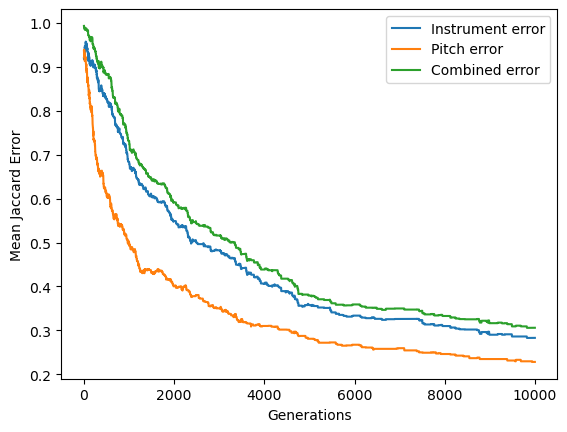

In [11]:
plt.plot(j_i_mean, label="Instrument error")
plt.plot(j_p_mean, label="Pitch error")
plt.plot(j_ip_mean, label="Combined error")
plt.xlabel("Generations")
plt.ylabel("Mean Jaccard Error")
plt.legend()

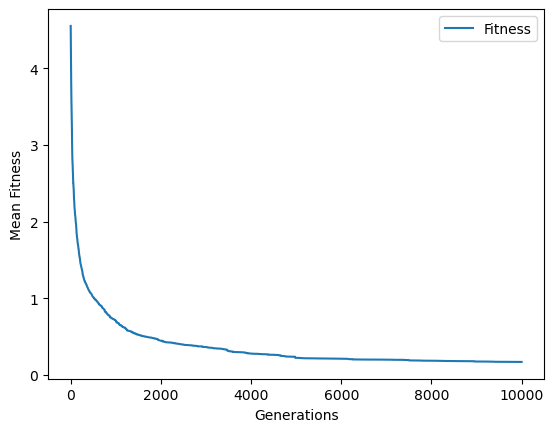

In [26]:
fitness_padded = []
for log in fitness_logs:
    fit = []
    for val in log:
        fit.append(val)
    while len(fit) < MAX_STEPS:
        fit.append(0)
    fitness_padded.append(fit)
fitness_means = np.mean(fitness_padded, axis=0)
plt.plot(fitness_means, label="Fitness")
plt.xlabel("Generations")
plt.ylabel("Mean Fitness")
plt.legend()